# **Подходы к интерпретации и визуальному представлению полученных интерпретаций для алгоритма линейной регрессии.**

[datablog, 5.12.2024](https://t.me/jdata_blog)

Привет, друзья! Этот практический ноутбук сделан с целью вдохновить вас на разносторонее и аккуратное использование весов регрессии. Ноутбук является частью открытого курса "Интерпетируемые модели AI" и содержит практические задачи, заполняемые на платформе.

Приятного Изучения!

### **Ограничения применения модели:**

1. Признаки $x_i$ должны линейно влиять на целевую переменную. Это обосновано тем, что линейная регрессия применяется на основе предположения о том что целевая переменная линейно зависит от признаков с постоянным шумом $ϵ$ $y = (w, x) + ϵ$([вероятностная постановка задачи](https://habr.com/ru/articles/514818/#secProbability)).  Кроме того, сам шум $ϵ$ должен быть распределен [нормальным образом](https://ru.wikipedia.org/wiki/Нормальное_распределение). \
\
В случае нелинейности влияния признаков на целевую переменную, можно попробовать исправить ситуацию преобразованием данных.

  **Для непрерывных признаков:** логарифмирование, извлечения корня, взятие синуса, `z-score` преобразование, `StandardScaler`, `MinMaxScaler` и [другие преобразования](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
  
  **Для категориальных признаков:** One-Hot encoding. Для избежания линейной зависимости удаляется столбец одной из категорий, однако это делается не всегда — только если в датасете прдеставлены ВСЕ возможные категории, которые будет обрабатывать модель (иными словами, нет строчек, где все категории тренировочного набора данных равны 0).  \

  Также можно скомбинировать подходы. Например, разбить непрерывный признак на квантили [`pd.cut, pd.qcut`](https://pbpython.com/pandas-qcut-cut.html)

 **Проверить выполнение предположения о нормальном распределении шума** можно, рассмотрев остатки линейной регрессии. Именно из нормального распределения шума следует MSE как функция потерь.

2. Независимые переменные (признаки) должны быть линейно независимы друг относительно друга.


### **Интерпретируемость**

Линейная регрессия относиться к [интерпретируемым](https://habr.com/ru/articles/744866/) алгоритмам. Важность признаков лежит внутри весов модели, но чтобы этот факт был полностью корректным важно помнить, что:

- данные должны быть приведены к единому машстабу.
- должна быть выполнена кодировка категориальных признаков (например, через OHE).

**В этом ноутбуке** приведены 5 методов для представления информации, которая заложена в весах модели:

1. Прямое рассмотрение коэффициентов в виде барплота.
2. Представление коэффициентов виде круговой диаграммы.
3. Рассмотрение относительного вклада коэффициентов.
4. Анализ остатков модели.
5. Построение регионов уверенности.

**Анализ вкладов признаков в том числе способен:**

- выявить причины плохого построения;
- построить гипотезы для улучшения модели.

**Приведенные в ноутбуке методы призваны помочь:**
- улучшить понимание интерпретируемости модели;
- дать практические способы представлять важность вкладов, донося разные информационные сообщения для аудитории;
- дать практические способы дебаггинга модели на основе вкладов;

Приступим.

Для начала просто обучим модель.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error

Фиксируем случайность.

In [ ]:
RANDOM_STATE = 42

В качестве подопытного набора данных используем [датасет о домах в Калифорнии](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset), с целевой переменной y, отрадающей медианную стоимость дома в сотнях тысяч долларов (США).

In [ ]:
path = 'https://github.com/SadSabrina/interpretable_AI_course/raw/refs/heads/main/data/housing.csv'
data = pd.read_csv(path, index_col=0)

X = data.drop('MedHouseVal', axis=1)
y = data['MedHouseVal']

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Разделим данные на тренировочную и тестовую выборки, не забыв про машстабирование.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.25)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучим линейную регрессию, и сравним предсказание с базовым — всем домам будем просто прогнозировать среднее по обучающей выборке.

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

predictions = lr.predict(X_test_scaled)
base = np.array([y_train.mean()]*len(X_test)) # будем просто прогнозировать среднее

print('Качество базового алгоритма (MAE): ', mean_absolute_error(y_test, base))
print('Качество линейной регрессии (MAE): ', mean_absolute_error(y_test, predictions))

Качество базового алгоритма (MAE):  0.9100474990475331
Качество линейной регрессии (MAE):  0.5296964012919462


In [ ]:
from sklearn.metrics import r2_score

print('Качество базового алгоритма (R2): ', r2_score(y_test, base))
print('Качество линейной регрессии (R2): ', r2_score(y_test, predictions))

Качество базового алгоритма (R2):  -3.8775657694056775e-05
Качество линейной регрессии (R2):  0.5910509795491351


Не отлично, но и не ужасно! Регрессия построена, она лучше базовой, но всё же построена не очень хорошо. Это на самомо деле связано с природой данных. Можно ли это **выявить и показать**? Рассмотрим далее.

## **Метод 1. Визуализация коэффициентов в виде столбчатой диаграммы.**

После обучения линейной регрессии у нас есть веса — значения, которые представляют собой для каждого признака силу их вклада в прогноз.

Признаки хранятся в атрибуте lr.coef_

In [ ]:
labels = X_train.columns #названия признаков
values = # Ваш код здесь — запишите веса

Для начала посмотрим на табличные значения.

In [ ]:
weights_data = pd.DataFrame(values, index=labels, columns=['weitght'])

weights_data

,weitght
MedInc,0.852108
HouseAge,0.120655
AveRooms,-0.302106
AveBedrms,0.348606
Population,-0.001645
AveOccup,-0.041164
Latitude,-0.893147
Longitude,-0.867840


**Задание 1.**

Какой признак является самым значимым в модели?

(`Ваш ответ`)

Веса могут быть как положительными, так и отрицательными. Знак отражает тенденцию линейной взаимосвязи.

Первый метод представить их более визуально приятно — столбчатая диаграмма барплот. Первый вариант — сохраняя тенденции взаимосвязи:

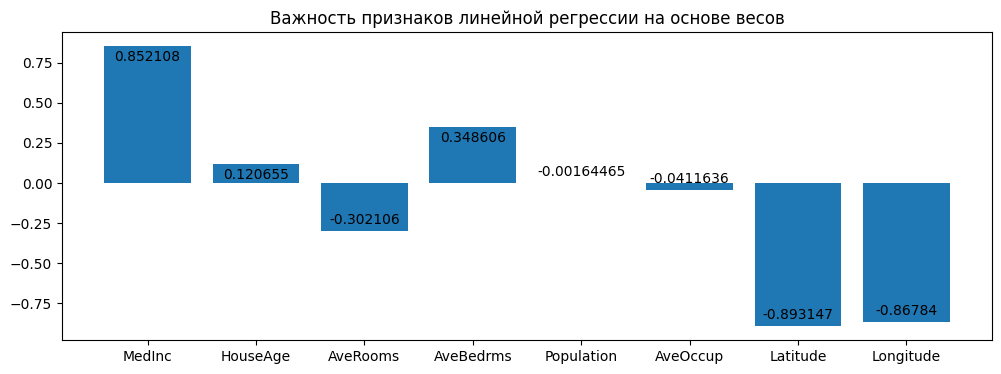

In [ ]:
plt.figure(figsize=(12, 4))

bar = plt.bar(height=lr.coef_, x=labels)

plt.bar_label(bar, padding=-13, color='black')

plt.title('Важность признаков линейной регрессии на основе весов');

Второй — визуализируя абсолютные значения:

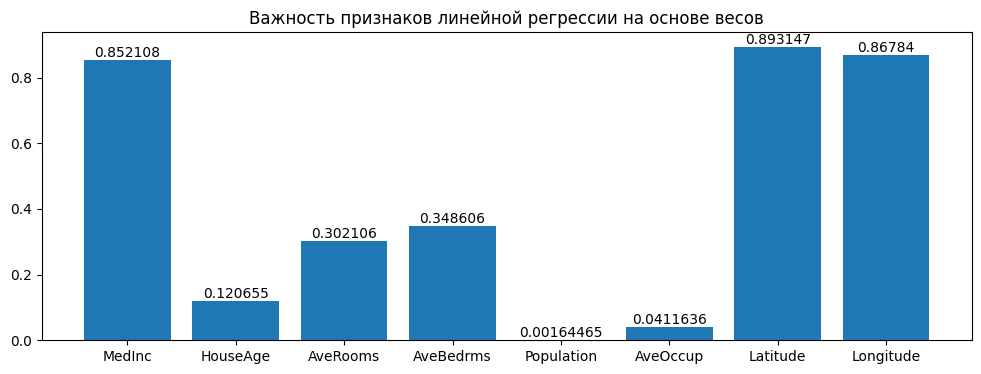

In [ ]:
plt.figure(figsize=(12, 4))

# Поправьте код так, чтобы отразить абсолютные значения весов

bar = plt.bar(height=values, x=labels)
plt.bar_label(bar, color='black')

plt.title('Важность признаков линейной регрессии на основе весов');

# Метод 2. Визуализация коэффициентов при помощи круговой диаграммы

Круговая диаграмма (pie plot) — не менее наглядный способ визуального представления важностей. Плюс такого графика — отличное долевое представление весов. Минус — не удобно отражать информацию о положительности/отрицательности связи.

**Обратите внимание:** в pie plot необходимо подавать аюсолютные значения весов.

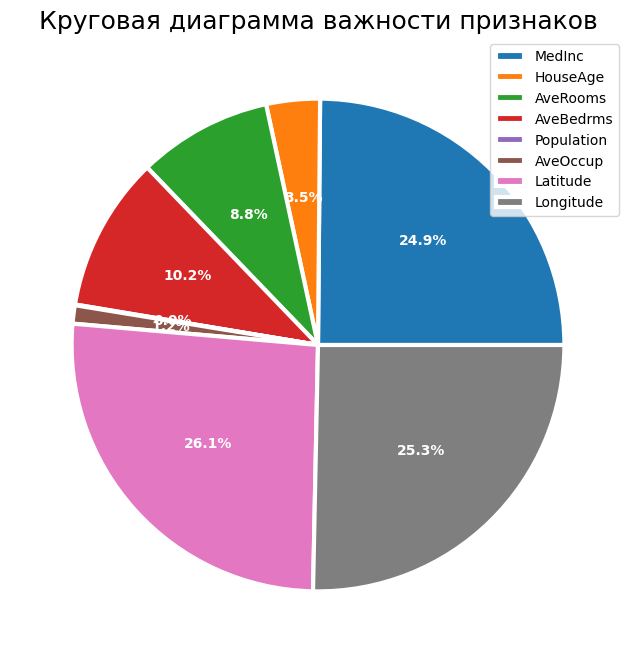

In [ ]:
plt.figure(figsize=(8, 8))
patches, texts, pcts = plt.pie(np.abs(lr.coef_), autopct='%1.1f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},);

plt.setp(pcts, color='white', fontweight='bold')

plt.legend(X_train.columns);

plt.title('Круговая диаграмма важности признаков', fontsize=18);

Такой способ подходит в случа, когда вам важно *донести относительную значимость* признака среди других визуально. Это аккуратно подводит нас к третьему сопособу — вычислению этой важности в лоб.

# Метод 3. Вычисление относительной важности признаков

И так — относительная важность. Её мы видели выше на знаниях круговой диаграммы. Вклад признака расчитывается за счет нормирования каждого коэффициента модели на сумму абсолютных значений всех весов.

Её также можно потом визуализировать, барплотом или как раз круговой диаграммой выше (для этого предварительные вычисления, как мы убедились, не нужны). Но в виде таблицы, заранее отсортированной, представление также является  наглядным.

In [ ]:
#Сделаем чуть более удобный датафрейм

# Поправьте код так, чтобы не было отрицательных значений в процентах.

weights_data2 = pd.DataFrame([labels, values]).T
weights_data2.columns = ['feature', 'feature_weitght']

weights_sum2 = sum(abs(weights_data2['feature_weitght']))

weights_data2['feature_weitght_normalized'] = weights_data2['feature_weitght'].apply(lambda x: round(x/weights_sum2*100, 2))

In [ ]:
weights_data2.sort_values(by='feature_weitght_normalized', ascending=False)

,feature,feature_weitght,feature_weitght_normalized
0,MedInc,0.852108,24.86
3,AveBedrms,0.348606,10.17
1,HouseAge,0.120655,3.52
4,Population,-0.001645,-0.05
5,AveOccup,-0.041164,-1.20
2,AveRooms,-0.302106,-8.81
7,Longitude,-0.86784,-25.32
6,Latitude,-0.893147,-26.06


**Задание 2.**

Проанализируйте относительные вклады признаков в модель. Выберите утверждения, которые относятся к относительным значениям.  

# Метод 4. Анализ распределений остатков

Анализ остатков регрессионной модели изначально применяется для оценки её качества. Подробнее про регрессионный анализ [тут](http://www.machinelearning.ru/wiki/index.php?title=%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D0%BE%D1%81%D1%82%D0%B0%D1%82%D0%BA%D0%BE%D0%B2).

А мы сосредоточимся на интерпретации. Первый способ — рассмотреть ожидаемые и прогнозируемые значения в виде диаграммы рассеивания.

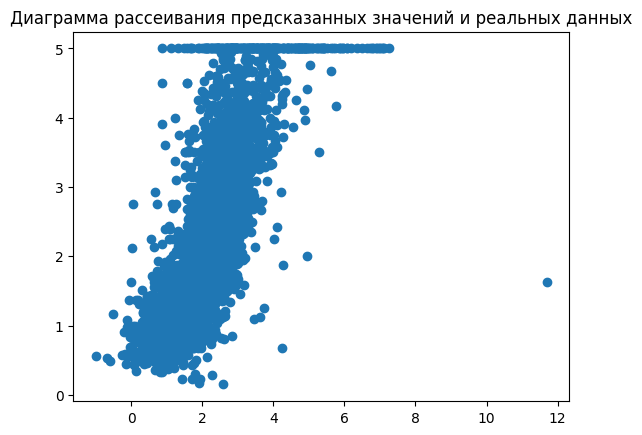

In [ ]:
plt.scatter(predictions, y_test)
plt.title('Диаграмма рассеивания предсказанных значений и реальных данных');

Здесь, например, видно, что на больших значениях модель ведет себя странным образом.

Второй, не менее красивый способ увидеть это — наложить распределения прогнозируемых и ожиданиемых друг на друга. Например, так:

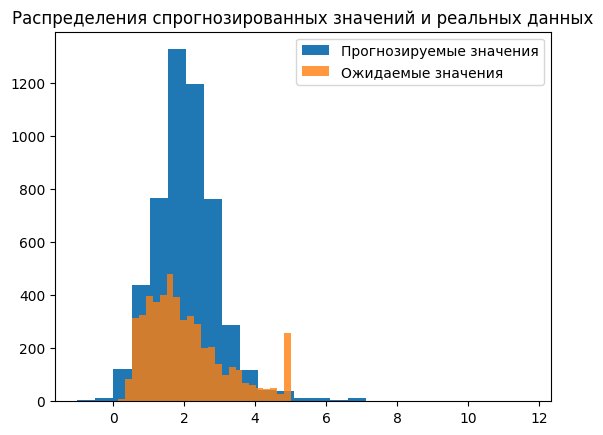

In [ ]:
residuals = # Ваш код здесь. Вычислите абсолютные значения остатков модели

plt.hist(predictions, label='Прогнозируемые значения', bins=25);
plt.hist(y_test, label='Ожидаемые значения', bins=25, alpha=0.8);

plt.title('Распределения спрогнозированных значений и реальных данных')
plt.legend();

Так участки проблемных значений видны ещё лучше.

**Задание 3.**

Проанализируйте график. Что не так с моделью? Выберите верные утвереждения на степик.

# Метод 5. Анализ регионов уверенности на основе остатков.

Из прошлых графиков ясно, что модель где-то справляется не очень хорошо. Везде ли это происходит? Ответить на вопрос поможет анализ регионов уверенности **на основе остатков**.

### **Суть метода**

Идея этого метода — рассмотреть и продемонстрировать, в каких областях признаков модель более уверена в своих предсказаниях, а в каких — менее. Более просто понять это на задаче классификации.

**Пример:**

Пусть есть модель, которая прогнозирует для онлайн-пользователя наличие (1) или отсутствие (0) выручки. Пусть для задачи нам наиболее важно прогнозирование отсутствия выручки. Тогда мы можем:

- выделить наблюдения класса 0;
- на основе вероятностей, выдаваемых моделью, разделить данные на интервалы:

 - низкая уверенность (вероятность "0" < 0.3).
 - средняя уверенность (0.3 <= вероятность "0" < 0.7).
 - высокая уверенность (вероятность "0" >= 0.7).
- посмотреть, для каких объектов уверенность модели низкая и провести по ним EDA.


**Задача регрессии.**

Для задачи регрессии всё тоже применимо. Мы можем разбить прогнозируемые наблюдения по квантилям абсолютных значений остатков. Например:

- класс 0 — остатки ниже 25 квантиля
- класс 1 - остатки больше 25, но ниже 75 квантиля
- класс 2 - остатки от 75 квантиля

Далее наши визулизации будут касаться распределений признаков по одной оси и целевой переменной по другой. Пример ниже:

In [ ]:
residuals = pd.Series(abs(predictions - y_test))

q1 = residuals.quantile(0.25)  # 25-й квантиль
q2 = # Ваш код здесь — выделите 75-й квантиль

# Создание групп на основе остатков
residuals_groups = pd.cut(
    residuals,
    bins=[-float('inf'), q1, q2, float('inf')],  # Диапазоны квантилей
    labels=['группа 1: <25%', 'группа 2: 25-75%', 'группа 3: >75%']  # Метки групп
)

In [ ]:
residuals['resid_class'] = residuals_groups

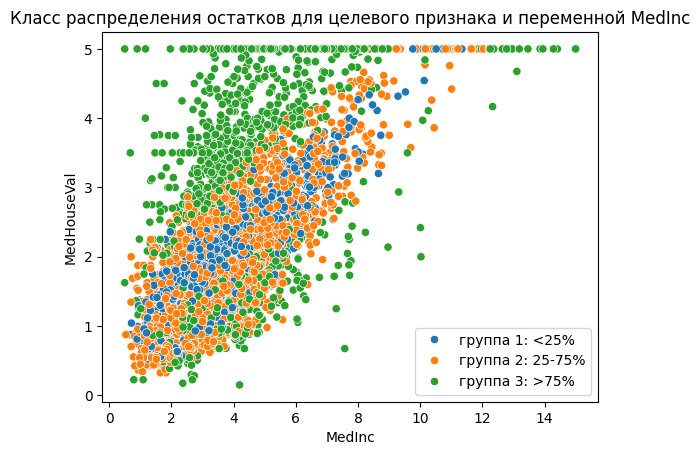

In [ ]:
sns.scatterplot(x=X_test['MedInc'], y=y_test, hue=residuals['resid_class']);

plt.legend();
plt.title('Класс распределения остатков для целевого признака и переменной MedInc');

По графику видно, что наблюдения, вырывающиеся из линейного облака  связи двух переменных имеют максимальные по модулю значения остатков. Следовательно либо в данных есть выбросы и шум, либо предположение о линейности связи для признака не выполнено — этот момент по определению будет затруднять высококачественную аппроксимацию целевой переменной линейной регрессией.

**Задание 5.**

Проанализируйте график в ноутбуке. Какое (или какие) противоречие мешает линейности связи, и где она наблюдается?

На этом всё, друзья! Мы рассмотрели 5 методов для анализа и представления весов и прогнозов регрессии. Желаю вам продуктивной работы и учебы с данными!  

Встретимся в новых постах и практиках,  \
Ваш Дата-автор!